c:\Users\cjpai\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


Close        1.000000
Low          0.999933
High         0.999928
Open         0.999853
Adj Close    0.998659
Volume      -0.333086
Name: Close, dtype: float64


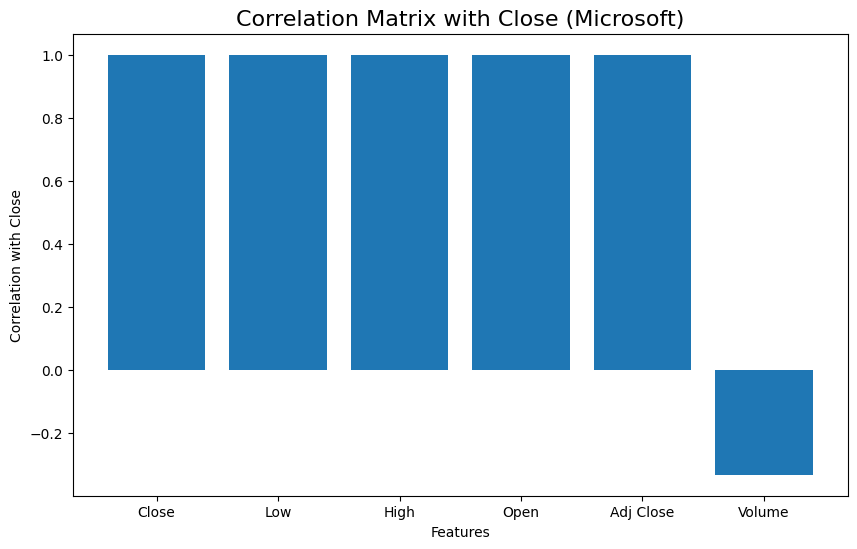

Close               1.000000
Yearly_MA           0.987021
ATR                 0.927352
Year                0.722793
Garman Klass Vol    0.629497
OBV                 0.434842
RSI                 0.063139
Month               0.036098
Day                 0.002995
Name: Close, dtype: float64


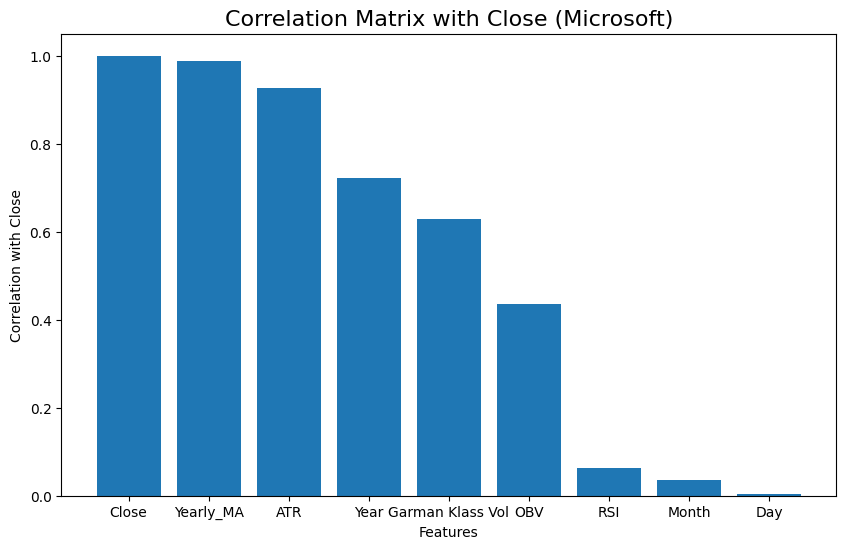

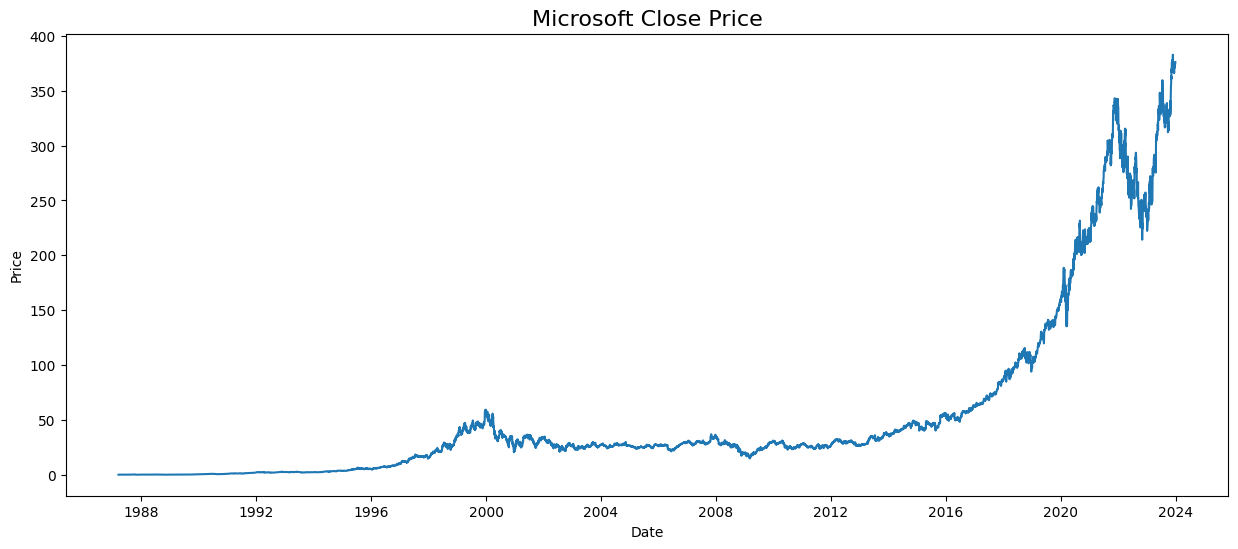

Mean Absolute Error:  131.45807916685447
Mean Squared Error:  26179.550967006926
R2 Score:  -1.9623630875479026
Average difference between actual and predicted values: 59.38%


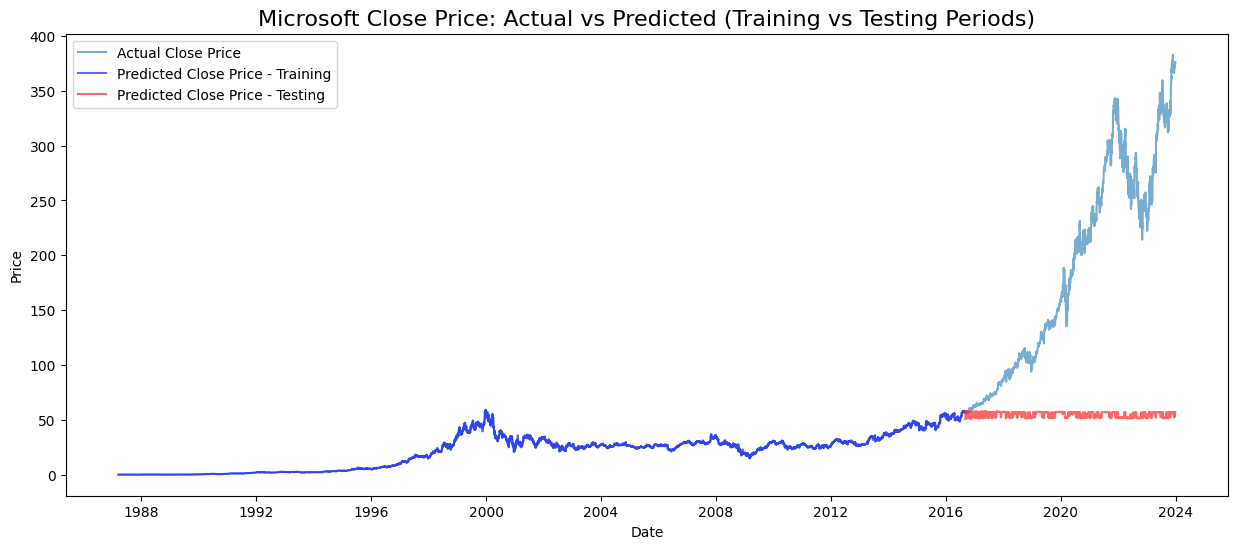


Microsoft Feature Importance:
Yearly_MA: 0.934668814282907
OBV: 0.027259302897167208
Garman Klass Vol: 0.015137283767777789
Year: 0.010086221795808321
ATR: 0.007359487012352442
RSI: 0.003554225932123969
Month: 0.001901677896439326
Day: 3.298641542382811e-05


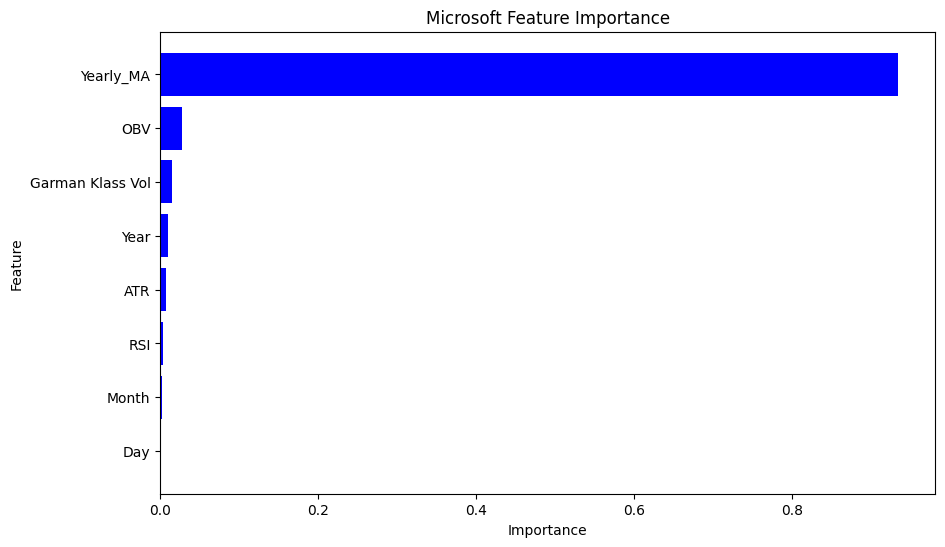

In [1]:
import yfinance as yf 
import pandas as pd 
import numpy as np
import pandas_ta as ta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the data
data = yf.download('MSFT', start='1986-03-13', end='2024-01-01')

# Create correlation matrix with taret 'Close'
correlation_matrix = data.corr()['Close'].sort_values(ascending=False)
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
plt.bar(correlation_matrix.index, correlation_matrix.values)
plt.title('Correlation Matrix with Close (Microsoft)', fontsize=16)
plt.xlabel('Features')
plt.ylabel('Correlation with Close')
plt.xticks(rotation=0)
plt.show()

# Add new features
data['RSI'] = ta.rsi(data['Close'])
data['OBV'] = ta.obv(data['Close'], data['Volume'])
data['ATR'] = ta.atr(data['High'], data['Low'], data['Close'])
data['Yearly_MA'] = data['Close'].rolling(window=256).mean()
data['Garman Klass Vol'] = ((np.log(data['High']) - np.log(data['Low'])) ** 2) / 2 - (2 * np.log(2) - 1) * ((np.log(data['Adj Close']) - np.log(data['Open'])) ** 2)
data['Day'] = data.index.dayofweek
data['Month'] = data.index.month
data['Year'] = data.index.year

# Drop missing values
data = data.dropna()

# Keep only the 'Close' and the new features
data = data[['Close', 'RSI', 'OBV', 'ATR', 'Yearly_MA', 'Garman Klass Vol', 'Day', 'Month', 'Year']]

# Create correlation matrix with taret 'Close'
correlation_matrix = data.corr()['Close'].sort_values(ascending=False)
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
plt.bar(correlation_matrix.index, correlation_matrix.values)
plt.title('Correlation Matrix with Close (Microsoft)', fontsize=16)
plt.xlabel('Features')
plt.ylabel('Correlation with Close')
plt.xticks(rotation=0)
plt.show()

# Plot the close price
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['Close'])
plt.title('Microsoft Close Price', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Build Random Forest model to precict 'Close'

# Seperate features and target
X = data.drop('Close', axis=1)
y = data['Close']

# Create scaler instance, then scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Model build
model = RandomForestRegressor(n_estimators=100)

# Train model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Calculate the performance metrics
MAE = mean_absolute_error(y_test, predictions)
MSE = mean_squared_error(y_test, predictions)
R2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error: ", MAE)
print(f"Mean Squared Error: ", MSE)
print(f"R2 Score: ", R2)

# Calculate the average difference between the actual and predicted values as a percentage
average_difference = np.mean(np.abs(predictions - y_test.values) / y_test.values) * 100
print(f"Average difference between actual and predicted values: {average_difference:.2f}%")

# 1. Scale the entire dataset (X)
X_scaled_full = scaler.transform(X)  # X is your feature set without the 'Close' column

# 2. Make predictions on the entire scaled dataset
predictions_full = model.predict(X_scaled_full)

# Calculate the split index
split_idx = len(X_train)

# Dates for plotting
dates = data.index

# Actual Close prices plotting remains the same
plt.figure(figsize=(15, 6))
plt.plot(dates, y, label='Actual Close Price', alpha=0.6)

# Plot predicted values for the training period
plt.plot(dates[:split_idx], predictions_full[:split_idx], label='Predicted Close Price - Training', color='blue', alpha=0.6)

# Plot predicted values for the testing period
plt.plot(dates[split_idx:], predictions_full[split_idx:], label='Predicted Close Price - Testing', color='red', alpha=0.6)

plt.title('Microsoft Close Price: Actual vs Predicted (Training vs Testing Periods)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Feature Importance
feature_importance = model.feature_importances_
feature_names = X.columns

sorted_feature_importance = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)

feature_importance_dict = dict(sorted_feature_importance)

print('\nMicrosoft Feature Importance:')
plt.figure(figsize=(10, 6))
for feature, importance in sorted_feature_importance:
    print(f'{feature}: {importance}')
    plt.barh(feature, importance, color='blue')

plt.title('Microsoft Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # invert the y-axis to have the most important feature at the top
plt.show()
